In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import datetime
import urllib
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
from scipy import stats
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
% matplotlib inline

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
lm = LinearRegression()
LR=LogisticRegression
LRCV=LogisticRegressionCV

In [3]:
def renaming(x):
    new_name=""
    if x==("Junior Data Scientist"or"Entry Level Data Scientist" or "Data Scientist II" or "Associate Data Scientist"):
        new_name="Junior DS"
    elif x==("Senior Data Scientist" or "Principal Data Scientist"):
        new_name=="Senior DS"
    else:
        new_name="DS"
    return new_name
def name_change(x):
    new_value=""
    if x in change.keys():
        new_value=change[x]
    else:
        new_value=x
    return new_value
def cap(x):
    value=0
    if x is np.NAN:
        value="Unknown"
    elif x>2000:
        value="Hugecap"
    elif x>500:
        value="Largecap"
    elif x>100:
        value="Midcap"
    else:
        value="Smallcap"
    return value
def create_bins(low,high,n):
    increment=(high-low)/float(n)
    bins=[]
    for i in range(n+1):
        bins.append(low+increment*(i))
    replacements=[]
    i=0
    while i<len(bins)-1:
        replacements.append(str(int(round(bins[i])))+"-"+str(int(round(bins[i+1]))))
        i+=1
    return bins,replacements
def salary_bin(bins,replacements,x):
    i=0
    value=0
    while i<len(bins)-1:
        if x<=int(round(bins[i+1])):
            value=replacements[i]
            i=len(bins)
        i+=1
    if value==0:
        value=str(bins[-1])+"+"
    return value
def only_numerics(seq):
    seq = seq.split('-')
    try:
        out = ((int(filter(type(seq[0]).isdigit, seq[0])) + int(filter(type(seq[1]).isdigit, seq[1])))/2)*1000
    except:
        out = int(filter(type(seq[0]).isdigit, seq[0]))
    return out


Uploads the non-Glass Door data.
The stock data is cleaned for:
* Certain terms in the name. Things like 'inc,' or 'corp' are deleted. This helps the matching process.
* The market cap information is converted from strings to millions of dollars.

The city data is cleaned for:

* Cities containing '-'
* Cities containing 'county'
* Removing ',' from city names

In [4]:
#Cleans up the Stock information
nyse=pd.read_csv("Data/NYSE.csv")
nasdaq=pd.read_csv("Data/NASDAQ.csv")
amex=pd.read_csv("Data/AMEX.csv")
stocks=nyse.append(nasdaq,ignore_index=True).append(amex,ignore_index=True)
del stocks["Summary Quote"]
i=0

We had discrepancies between the names of the scraped Glass Door data, and the names of the stock information. This led to information not being merged when it should have. So, we manually searched for the pairs of names and input them into a dictionary. This dictionary would be used to rename the mislabeled Glass Door entries.

In [5]:
"""ONLY USED FOR FINDING STOCKS"""

names=[x for x,y in zip(stocks["Name"].value_counts().sort_values(ascending=False).index,\
                        stocks["Name"].value_counts().sort_values(ascending=False).values) if y>1]

names=['Price']

#Finds all instances of a company name within stocks["Name"], and prints the instance and its index numer
for name in names:
    i=0
    while i<len(stocks):
        if stocks.loc[i,"Name"]==name:
            print "index: ",i
            print stocks.iloc[i]
            print "\n"
        i+=1

# [x for x in stocks["Name"] if x[0:3]=="Exp"] #-->Additional Search Method; looks for first three letters
# [x for x in stocks["Name"] if "Price".lower() in x.lower()]

In [6]:
change={"GE": "General Electric Company", "IBM":"Microsoft","Capital One":"Capital One Financial",
        "Verizon":"Verizon Communications","Hewlett Packard Enterprise | HPE":'Hewlett Packard Enterprise Company',
       "Hewlett-Packard":'Hewlett Packard Enterprise Company',"Alliance Data":"Alliance Data Systems",
       'Raytheon':'Raytheon Company',"GE":'General Electric Company',"Verizon Wireless":"Verizon Communications",
       "Intel Corporation":"Intel","MaxPoint":"MaxPoint Interactive","General Motors":"General Motors Company",
       "Booz Allen Hamilton":"Booz Allen Hamilton Holding","Nielsen":"Nielsen N.V.","SAP":"SAP SE",
       "General Dynamics Mission Systems":"General Dynamics","Leidos":"Leidos Holdings",
       "Honeywell":"Honeywell International","Akamai":"Akamai Technologies","BNY Mellon":"Bank Of New York Mellon",
       "FIS":"Fidelity National Information Services","J.P. Morgan":'J P Morgan Chase & Co',
       "Walmart":'Wal-Mart Stores',"PayPal":"PayPal Holdings","Adobe":"Adobe Systems",'AOL':"Verizon Communications"}

In [7]:
while i<len(stocks["Symbol"]):
    if " (The)" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" (The)")]
    if " Incorporated" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Incorporated")]
    if ", Inc." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc.")]
    if ", Inc" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc")]
    if ", INC" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc")]
    if " Inc." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc.")]
    if " Inc" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc")]
    if " INC" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc")]
    if  " Corporation" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corporation")]
    if " Corp." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp.")]
    if " Corp" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp")]
    if " CORP" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp")]
    i+=1

#Convert MarketCap to Millions of dollars
i=0
while i<len(stocks["MarketCap"]):
    if "B" in str(stocks.iloc[i,3])[-1:]:
        stocks.iloc[i,3]=float(str(stocks.iloc[i,3])[1:-1])*1000
    else:
        stocks.iloc[i,3]=str(stocks.iloc[i,3])[1:-1]
    i+=1

stocks=stocks.reset_index()
del stocks['index']

#Cleans cities data (eliminates counties and combined cities/towns)
cities=pd.read_csv("Data/Living_Index.csv")
cities=cities.rename(columns={"Urban Area":"City"})
values=[]
for x in cities["City"]:
    if "-" in x:
        values.append(False)
    else:
        values.append(True)
cities=cities[values]
values=[]
for x in cities["City"]:
    if "county" in x.lower():
        values.append(False)
    else:
        values.append(True)
cities=cities[values]
new_city_list=[]

for x in cities["City"]:
    y=x[-4:]
    z=x[:-len(y)].replace(",","")+y
    new_city_list.append(z)
cities["City"]=new_city_list

We initiate a Glass Door data frame to connect the json to.
We upload the json, which has four columns:
* Location
* Company
* Salary
* Job

We clean the json df for:
* Changing salary ranges to averagees

We save the json df as 'glass_door'.

We clean the glass_door df for:
* Name changes found listed above

We merge the glass_door df with cities. 

We create a new column "Normalized Salary".

In [8]:
glass_door=pd.DataFrame(columns=["Salary","Company","Location"])

extension="Data/allcities.json"
json=pd.read_json(extension)
df=pd.DataFrame([json["city"],json["company"],json["meanPay"],json["jobTitle"]]).T
df.columns=["Location","Company","Salary","Job"]
temp=[]


df['Salary'] = df['Salary'].apply(only_numerics)
df=df[pd.notnull(df["Salary"])].reset_index()
del df['index']
df["Salary"]=df['Salary'].astype(np.float)#

glass_door=glass_door.append(df,ignore_index=True)

glass_door["Company"]=glass_door["Company"].apply(lambda x: name_change(x))

glass_door=glass_door.merge(cities, left_on="Location", right_on="City")
glass_door["Normalized Salary"]=glass_door["Salary"]/glass_door["100% Composite Index"]

In [9]:
df=glass_door.copy()
df=df.merge(stocks, how='left',left_on="Company",right_on="Name")
len(df)

1512

We merge the glass_door df with stocks. We only select those Jobs that are Junior Level, Middle Level, or Senior Level. We dont want to end up with internships. We then bin the jobs with their respective bin names (as just mentioned).

For the most recurring private companies, market cap and sectors were updated as they had an impact on prediction ability.

Null values in market cap and sector were changed appropriately.

In [10]:
df=glass_door.copy()
df=df.merge(stocks, how='left',left_on="Company",right_on="Name")

keep=[ "Data Scientist", "Senior Data Scientist" , "Principal Data Scientist" ,"Junior Data Scientist" ]
#"Entry Level Data Scientist" , "Data Scientist II" , "Associate Data Scientist"
df=df.reset_index()
del df['index']

i=0
indices=[]
while i<len(df):
    if df.loc[i,"Job"] not in keep:
        indices.append(i)
    i+=1
indices.sort()
indices=indices[::-1]
for key in indices:
    df=df.iloc[:key].append(df.iloc[key+1:])
df=df[df["Salary"]>60000]
df=df.reset_index()
del df['index']



df["Job"]=df["Job"].apply(lambda x: renaming(x))



marketcap_sectors={'KPMG':[24440,"Consulting"],'Razorfish':[np.NaN,"Technology"],
                   'Elevate Credit':[640,"Finance"],'BCG Digital Ventures':[np.NaN,"Finance"]}

df=df.reset_index()
del df["index"]
i=0
while i<len(df):
    if df.loc[i,"Company"] in marketcap_sectors.keys():
        df.loc[i,"MarketCap"]=marketcap_sectors[df.loc[i,"Company"]][0]
        df.loc[i,"Sector"]=marketcap_sectors[df.loc[i,"Company"]][1]
    i+=1

df["Sector"]=["Technology" if pd.isnull(x) else x for x in df["Sector"]]
df["MarketCap"]=df["MarketCap"].apply(lambda x: cap(x))
#df["MarketCapSector"]=df["Sector"]+df["MarketCap"]

Here we convert the most relevant columns to dummy variables. We played around with this a lot, and found that Sector, Region, Job, MarketCap, and various living index components contributed positively to our logistic regression. All other columns were deleted.

Additionally, we found that normalizing the salary data against the total living index helped to make the salary data gaussian. So, we also multiplied all of the independent variables against their corresponding living index.

In [11]:
df2=pd.get_dummies(df,columns=["Sector","Region","Job","MarketCap"])
delete=[u'industry', u'Location', u'Salary',"State","City","Company",
       u'Symbol', u'Name', u'LastSale', u'IPOyear',u'Normalized Salary',u'100% Composite Index'] 
#u'13 % Grocery Items', u'29 % Housing',
#      u'10% Utilities', u'12 % Transportation', u'4% Health Care',
#       u'32 % Miscellaneous Goods and Services',
for x in delete:
    del df2[x]

normalizer=pd.DataFrame(df["100% Composite Index"].copy(),columns=["100% Composite Index"])
df2=df2.reset_index()
del df2['index']
normalizer=normalizer.reset_index()
del normalizer['index']
i=0
cols=df2.columns
while i<len(df2):
    for x in cols:
        df2.loc[i,x]=df2.loc[i,x]*normalizer.loc[i,"100% Composite Index"]
    i+=1

Below are plots demonstrating the strength of our coefficents and the normalization of our salaries. 

We decided to run a normal regression on our variables to see their predictive power. We figured that reducing the variance would greatly help our ability to classify our outputs for the logistic regression.

In [12]:
x_train2,x_test2,y_train2,y_test2=train_test_split(df2,df['Salary'],test_size=.35, random_state=20)

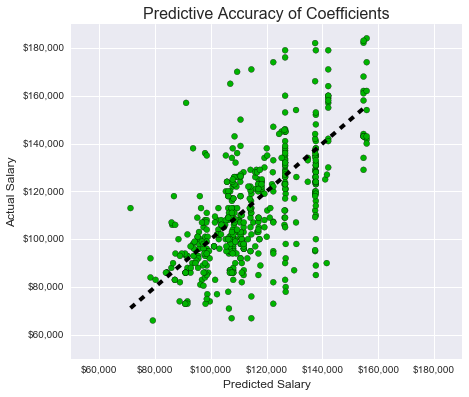

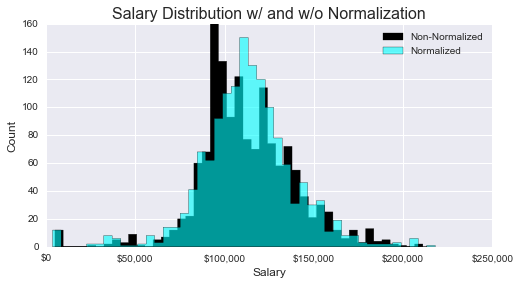

In [13]:
""" Fit a binary classification predictor."""
#Linear Regression
xtr=x_train2
xte=x_test2
ytr=y_train2
yte=y_test2

xtr=np.array(xtr).reshape(len(xtr),len(x_train2.columns))
xte=np.array(xte).reshape(len(xte),len(x_train2.columns))
xtr2=sm.add_constant(xtr)
model=sm.OLS(ytr,xtr).fit()

xte2=sm.add_constant(xte)
pred=model.predict(xte)

fig,axes=plt.subplots(figsize=(7,6))
plt.scatter(pred,yte,c=(0,.7,0,1),s=[35 for x in range(len(pred))])
temp=pred
temp.sort()
plt.plot(temp,temp,'--',c=(0,0,0,1),linewidth=4)
plt.xlim(50000,190000)
plt.ylim(50000,190000)
plt.xlabel("Predicted Salary",size=12)
plt.ylabel("Actual Salary",size=12)
plt.title("Predictive Accuracy of Coefficients",size=16)
plt.xticks(np.linspace(60000,180000,7),['$60,000','$80,000','$100,000','$120,000','$140,000','$160,000',
                                        '$180,000'])
plt.yticks(np.linspace(60000,180000,7),['$60,000','$80,000','$100,000','$120,000','$140,000','$160,000',
                                        '$180,000'])
plt.show()

#print model.summary2()```

##MAKE THIS PRETTIER; We will present with this

fig,ax=plt.subplots(figsize=(8,4))
average=np.mean(glass_door["100% Composite Index"])
#\plt.hist(glass_door["Salary"]/average,width=50)
plt.hist(glass_door["Salary"],bins=45,color=(0,0,0,1),histtype='stepfilled',label="Non-Normalized")
plt.hist(glass_door["Normalized Salary"]*115,bins=45,color=(0,1,1,.6),histtype='stepfilled',label="Normalized")
plt.xlabel("Salary",size=12)
plt.ylabel("Count",size=12)
plt.title("Salary Distribution w/ and w/o Normalization",size=16)
plt.legend(loc='upper right')
plt.xticks(np.linspace(0,250000,6),['$0',"$50,000","$100,000",'$150,000','$200,000','$250,000'])
plt.show()

The code below creates bin names for the salary data and classifies the correct output accordingly. This is used for the logistic regression.

In [16]:
#ENTER BINS BELOW
bin_NUMBER=3

temp2=pd.DataFrame(df["Salary"].copy(),columns=["Salary"])
bins2,replacements2=create_bins(min(temp2["Salary"]),max(temp2["Salary"]),bin_NUMBER)

temp=pd.DataFrame(df["Salary"].copy(),columns=["Salary"])
bins,replacements=create_bins(min(temp["Salary"]),max(temp["Salary"]),bin_NUMBER)
temp["Normalized Salary"]=temp["Salary"].apply(lambda x: salary_bin(bins,replacements,x))
#df1=pd.get_dummies(temp,columns=["Normalized Salary"])
df1=temp["Normalized Salary"]

For the logistic regression below, we found the optimal tunings for our logistic regression outputs by running a series of for loops to find the best calibrations parameters. Furthermore, we took the average of the precision, recall, and f1scores over the course of 20 different random_states to find a more fair score.

In [17]:
random=1
bestx0=0.
bestx1=0.
bestx2=0.
bestf1=0.



for x0_change in  np.linspace(-1.5,-1,5):
    for x1_change in np.linspace(.9,1.5,6):
        for x2_change in np.linspace(-3,-1.5,7):
            x_train,x_test,y_train,y_test=train_test_split(df2,df1,test_size=.35,stratify=df1,random_state=random)
            logreg = LogisticRegression(solver='lbfgs') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
            C_vals = np.linspace(1,1001,10)
            penalties = ['l2']

            gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, cv=2)
            gs.fit(x_train, y_train)

            logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
            cv_model = logreg.fit(x_train, y_train)
            cv_pred = cv_model.predict(x_test)

            y_score = cv_model.decision_function(x_test) # Submit these response, the output of model.decision_function

            i=0
            pred=[]
            for x in y_score:
                if x[0]+x0_change>(x[1]+x1_change and x[2]+x2_change):
                    pred.append(cv_model.classes_[0])
                elif x[1]+x1_change>(x[0]+x0_change and x[2]+x2_change):
                    pred.append(cv_model.classes_[1])
                elif x[2]+x2_change>(x[1]+x1_change and x[0]+x0_change):
                    pred.append(cv_model.classes_[2])
                i+=1
            cv_pred=pred

            """ Check your performance so far."""

            conmat = np.array(confusion_matrix(y_test, cv_pred))
            confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)
            
            if float(classification_report(y_test,cv_pred)[-15:-11])>bestf1:
                bestf1=float(classification_report(y_test,cv_pred)[-15:-11])
                bestx0=x0_change
                bestx1=x1_change
                bestx2=x2_change
                


KeyboardInterrupt: 

In [ ]:
prec=[]
recall=[]
f1score=[]
max_rand=6

for random in range(1,max_rand):
    x_train,x_test,y_train,y_test=train_test_split(df2,df1,test_size=.35,stratify=df1,random_state=random)
    logreg = LogisticRegression(solver='lbfgs') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
    C_vals = np.linspace(1,1001,10)
    penalties = ['l2']

    gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, cv=3)
    gs.fit(x_train, y_train)

    logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
    cv_model = logreg.fit(x_train, y_train)
    cv_pred = cv_model.predict(x_test)

    y_score = cv_model.decision_function(x_test) # Submit these response, the output of model.decision_function

    i=0
    pred=[]
    x0_change=bestx0
    x1_change=bestx1
    x2_change=bestx2
    for x in y_score:
        if x[0]+x0_change>(x[1]+x1_change and x[2]+x2_change):
            pred.append(cv_model.classes_[0])
        elif x[1]+x1_change>(x[0]+x0_change and x[2]+x2_change):
            pred.append(cv_model.classes_[1])
        elif x[2]+x2_change>(x[1]+x1_change and x[0]+x0_change):
            pred.append(cv_model.classes_[2])
        i+=1
    cv_pred=pred

    """ Check your performance so far."""

    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    
    prec.append(float(classification_report(y_test,cv_pred)[-35:-31]))
    recall.append(float(classification_report(y_test,cv_pred)[-25:-21]))
    f1score.append(float(classification_report(y_test,cv_pred)[-15:-11]))

print "Best f1:  ",bestf1
print "Best x0:  ",bestx0
print "Best x1:  ",bestx1
print "Best x2:  ",bestx2


#    
print "Number of bins:    ", bin_NUMBER
print "Random Iterations: ", max_rand-1
print 
print "Average Precision: ", np.mean(prec)
print "Average Recall:    ", np.mean(recall)
print "Average F1-Score:  ", np.mean(f1score)
print 
print "Variance Precision:", np.var(prec)
print "Variance Recall:   ", np.var(recall)
print "Variance F1-Score: ", np.var(f1score)
print 

print(confusion)
print classification_report(y_test,cv_pred)
#print cv_model.coef_

The markdown cells below represent our trials on only Senior Data Scientist positions, but reflect upon how the model changes with subsequent changes in the input parameters. The best f1-score we obtained surprisingly did not use job dummy variables.

## BEST with Junior Jobs and no Job Dummies
* Number of bins:    3
* Average Precision: 0.756315789474
* Average Recall:    0.754736842105
* Average F1-Score:  0.751052631579

## Best with No Junior Jobs and Job Dummies
* Number of bins:    3
* Average Precision:  0.755789473684
* Average Recall:     0.754210526316
* Average F1-Score:   0.75

## Best with No Junior Jobs and no Job Dummies
* Number of bins:    3
* Average Precision:  0.756315789474
* Average Recall:     0.754736842105
* Average F1-Score:   0.751052631579

## Standard Company Changes:
* Number of bins:    3
* Average Precision: 0.748947368421
* Average Recall:    0.748947368421
* Average F1-Score:  0.744736842105

## With Private Company changes:
* Number of bins:    3
* Average Precision: 0.755789473684
* Average Recall:    0.754210526316
* Average F1-Score:  0.75

## With PC changes and no Job Dummies:
* Number of bins:    3
* Average Precision: 0.756315789474
* Average Recall:    0.754736842105
* Average F1-Score:  0.751052631579

## Standard Company Changes:
* Number of bins:    3
* Average Precision: 0.748947368421
* Average Recall:    0.748947368421
* Average F1-Score:  0.744736842105

## With Private Company changes:
* Number of bins:    3
* Average Precision: 0.755789473684
* Average Recall:    0.754210526316
* Average F1-Score:  0.75

## With Private Company changes and Sector-MarketCap Bin:
* Number of bins:    3
* Average Precision: 0.753157894737
* Average Recall:    0.752105263158
* Average F1-Score:  0.748421052632

## With PC changes and no State Dummies:
* Number of bins:    3
* Average Precision: 0.723684210526
* Average Recall:    0.726842105263
* Average F1-Score:  0.72

## With PC changes and no Region Dummies:
* Number of bins:    3
* Average Precision: 0.754210526316
* Average Recall:    0.754210526316
* Average F1-Score:  0.748421052632

## With PC changes and no Job Dummies:
* Number of bins:    3
* Average Precision: 0.756315789474
* Average Recall:    0.754736842105
* Average F1-Score:  0.751052631579

## With PC changes, no J D, and no MarketCap Dummies


This is another regression on our input variables. It is of a different library, for added coefficient information.

The x_train,y_train,... can be found just above the other regression graphs.

In [ ]:
""" Fit a binary classification predictor."""
#Linear Regression
xtr=x_train2
xte=x_test2
ytr=y_train2
yte=y_test2

xtr=np.array(xtr).reshape(len(xtr),len(x_train2.columns))
xte=np.array(xte).reshape(len(xte),len(x_train2.columns))
xtr2=sm.add_constant(xtr)
model=sm.OLS(ytr,xtr).fit()

xte2=sm.add_constant(xte)
pred=model.predict(xte)

plt.plot(pred,yte,'o')
plt.plot(pred,pred,'-')
plt.xlim(0,200000)
plt.ylim(0,200000)
plt.show()

print model.summary()

In [ ]:
ridge=Ridge(alpha=10) #Ridge is .28269 at 230
lasso=Lasso(alpha=0.5) #Lasso is 0.289105 at 2.01
lr=LinearRegression() #Linear Regression is .2763265
model=lasso.fit(x_train2,y_train2)
pred=model.predict(x_test2)
plt.scatter(pred,y_test2)
plt.plot(pred,pred)
plt.ylim(0,200000)
plt.xlim(0,200000)
plt.show()
print model.score(x_test2, y_test2)
print "\n"
coef=[]
for x,y in zip(x_test2.columns,model.coef_):
    coef.append([x,y])

In [ ]:
for j in range(len(logreg.classes_)):

    FPR, TPR, _ = roc_curve(y_test, [i[j] for i in y_score], pos_label=logreg.classes_[j])
    ROC_AUC = auc(FPR, TPR)

    amounts = logreg.classes_[j].split('-')
    title = 'Receiver operating characteristic for salary range \${} to \${}'.format(amounts[0], amounts[1])

    plt.figure(figsize=[11,9])
    plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()